A lot of the starter code is copied from sanjay-learning-lecture4.ipynb

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [180]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [181]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [499]:
# -------------------------------------------------------------------
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out 
    
    def parameters(self):
        return [self.weight]

# -------------------------------------------------------------------
class FlattenConsecutive:
    
    def __init__(self, n): # flatten n consecutive elements
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape # B = training batch size; T = block size; C = embedding size
        x = x.view(B, T // self.n, C * self.n) # // is integer division
        if x.shape[1] == 1:
            x = x.squeeze(1) # remove the unnecessary dimension
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5) # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight # storing in .out so that we can do some tracing
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])  # a list (len 1 or 2) of tensors

# -------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, n, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.training = True
        # gamma, beta similar to weight, bias of Linear network
        self.gamma = torch.ones(1, n) 
        self.beta = torch.zeros(1, n)
        # how much does specific forward pass affect running mean and std
        self.momentum = momentum
        # buffers, for maintaining a running mean, std
        self.mean_running = torch.zeros(1, n)
        self.var_running = torch.ones(1, n)
    
    # important note: PyTorch expects x to be of the form NxC or NxCxL (dim = 0 or dim = (0,2))
    # our implementation expects x to be of the form NxC or NxLxC
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.var_running
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to variance = 1, mean = 0 (note: variance is std^2)
        self.out = self.gamma * xhat + self.beta
        
        # if training, update the buffers
        if self.training:
            with torch.no_grad():
                self.mean_running = self.mean_running * (1 - self.momentum) + xmean * self.momentum
                self.var_running = self.var_running * (1 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -------------------------------------------------------------------
class TanH:    
    
    def __call__(self, x):
        self.out = torch.tanh(x) 
        return self.out
    
    def parameters(self):
        return []

# -------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [183]:
# simpler way to globally set the randomness seed
# replaces the `g = torch.Generator().manual_seed(2147483647)`, and having to pass that in everywhere
torch.manual_seed(42)

In [508]:
##
# Defining the NN 
##

n_embd = 24 # number of dimensions in the character embeddings
n_hidden = 128 # number of neurons in a hidden layer

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), TanH(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), TanH(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), TanH(),
    Linear(n_hidden, vocab_size)
])

# parameter initialization
with torch.no_grad():
    # make last layer less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

76579

In [498]:
# Inspect layer output shapes
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (22655, 8, 10)
FlattenConsecutive : (22655, 4, 20)
Linear : (22655, 4, 68)
BatchNorm1d : (22655, 4, 68)
TanH : (22655, 4, 68)
FlattenConsecutive : (22655, 2, 136)
Linear : (22655, 2, 68)
BatchNorm1d : (22655, 2, 68)
TanH : (22655, 2, 68)
FlattenConsecutive : (22655, 136)
Linear : (22655, 68)
BatchNorm1d : (22655, 68)
TanH : (22655, 68)
Linear : (22655, 27)


In [478]:
## Scratchpad Start

# ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)
# print(Xb)

# print('embedding layer output shape', model.layers[0].out.shape)
# print('flatten layer output shape', model.layers[1].out.shape)
# print('linear layer output shape', model.layers[2].out.shape)
# print('')
# 
# print('Essentially, linear layer output is', (torch.rand(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# 
# # Important note: matrix multiplication in torch only requires the last dimensions to match.
# print('multi-dimensional scenario', (torch.rand(4, 7, 8, 9, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# print('')

# WAVENET: https://arxiv.org/pdf/1609.03499.pdf

# example input, 8 characters
# 1 2 3 4 5 6 7 8
# we want to group this into (1 2) (3 4) (5 6) (7 8)
# we can treat this as a batch dimension of 2

# flatten layer output should be: 
#   mini-batch of 4 examples 
#   x each example batched into two rather than all at once, leading to 8 (block_size) / 2 = 4
#   x two characters with embeddings = 20
#   so, 4x4x20
# print('WaveNet scenario', (torch.rand(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)
# to support this, we need Flatten to output based on above, how do we do this ?

# digression into list indexing
# a = list(range(10))
# print(a[1::2]) # prints every 2nd element starting from 1, for every odd

# e = torch.randn((8, 1), generator=torch.Generator().manual_seed(1)) # we want 8x1 to be 4x2
# explicitConcatenation = torch.cat([e[::2,:], e[1::2,:]], dim=1) # one way to do above is via explicit concatenation
# print('8x1\n', e)
# print('4x2\n', explicitConcatenation)
# print('4x2 via view\t', e.view(4,2))
# print((e.view(4,2) == explicitConcatenation).all())
# This works

# Important to note that the View method only works when increasing the later dimensions

## Scratchpad End

torch.Size([4, 8])
tensor([[ 6, 18,  1, 14,  3,  9, 14,  5],
        [ 0,  0,  0,  0,  0,  0, 14,  9],
        [ 0,  0,  8, 15, 12, 12,  9, 19],
        [ 0,  0,  0,  0, 15, 19, 20,  9]])


In [509]:
n_steps = 200000
batch_size = 32
lossi = []

for i in range(n_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)

    # Loss
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} /{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 / 200000: 3.2956
  10000 / 200000: 2.1509
  20000 / 200000: 1.6836
  30000 / 200000: 1.8574
  40000 / 200000: 1.9783
  50000 / 200000: 1.6760
  60000 / 200000: 1.8772
  70000 / 200000: 1.6335
  80000 / 200000: 2.1417
  90000 / 200000: 2.1305
 100000 / 200000: 1.8784
 110000 / 200000: 1.7506
 120000 / 200000: 1.7658
 130000 / 200000: 1.7405
 140000 / 200000: 1.9796
 150000 / 200000: 1.8425
 160000 / 200000: 1.7893
 170000 / 200000: 2.2474
 180000 / 200000: 1.6861
 190000 / 200000: 1.8284


# Flakiness in Loss Output
Increasing from 1.7 to 2.3 and such. 
Main reason is due to small batch sizes. You can get lucky or unlucky more easily with a very small batch size.

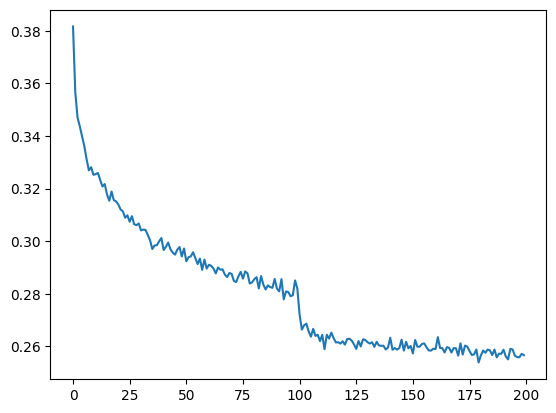

In [510]:
plt.plot(torch
 .tensor(lossi)
 .view(-1, 1000) # each row is a consecutive 1000, that we can take a mean of
 .mean(1))

In [511]:
# put layers into eval mode (for BatchNorm)
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

In [512]:
# evaluate the loss (entire dataset, no batching)
@torch.no_grad
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.786378026008606
val 1.9908310174942017


# Performance Log

| Set Up                                                                                           | Train |   Val |                                         Notes |
|--------------------------------------------------------------------------------------------------|:-----:|------:|----------------------------------------------:|
| Sequential model with 3 character context, embedding length 8, 200 hidden neurons, 12K params    | 2.058 | 2.105 |                                               |
| Sequential model with 8 character context, embedding length 8, 200 hidden neurons, 22K params    | 1.925 | 2.037 |                                               |
| Hierarchical model with 8 character context, embedding length 8, 68 hidden neurons, 22K params   | 1.948 | 2.032 |                                               |
| Fix bug in BatchNorm to take mean / variance with multi-dimensional inputs                       | 1.925 | 2.023 |                                               |
| Hierarchical model with 8 character context, embedding length 24, 128 hidden neurons, 76K params | 1.786 | 1.990 | hyperparameters being set without due process |


In [526]:
# sample from the model
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the NN
        logits = model(torch.tensor([context]))
        prob = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(itos[ix])
        # break if we sample the ending character
        if ix == 0:
            break
    print(''.join(out))
        
    

braylee.
zahi.
ilina.
jessaf.
avivaace.
nyhalha.
crayd.
ebul.
abduan.
taeya.


# Convolutional Neural Layers (as used in WaveNet paper)
This is strictly for efficiency.
Convolutions can be thought of a "for loop", that allows us to forward linear layers efficiently over space

??? What! TODO

In [639]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

# forward 8 examples manually
logits = torch.zeros(8,27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

# with this implementation, this is 8 independent calls to the model
# with convolutions, we can slide 

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


torch.Size([8, 27])

# At this point, we can consider ourself as understanding what's under the hood of PyTorch, especially torch.nn and can use that from here
YaY!!!

# Notes on NN Development
Spend a bunch of time in torch documentation pages, though, they might not be up-to-date
Spend a bunch of type prototyping the NN in Jupyter notebooks to ensure the shapes and functionality works as intended
Copy into a code repository once final and kick-off training